In [1]:
import tensorflow as tf
from tensorflow import keras, data
from tensorflow.keras import layers, models, utils

import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import os

2024-03-07 22:04:02.833899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 22:04:02.833944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 22:04:02.835611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 22:04:02.845521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 22:04:03.814567: W tensorflow/compiler/tf2

In [2]:
IMG_SIZE=96
BATCH_SIZE=16
LATENT_DIM=128

In [3]:
dataset_path = 'faces/'

processed = []

# Iterate through images, crop, scale and store them in 'processed' array
for img in tqdm(os.listdir(dataset_path)):
    img = cv2.imread(dataset_path+img) #read image
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           #convert to RGB
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))           #resize
    img = tf.cast(img,'float32')/127.5 - 1              #normalize image to [-1,1]
    processed.append(img)                               #store in array

  0%|          | 0/29042 [00:00<?, ?it/s]

2024-03-07 21:26:28.649450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 21:26:28.851214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 21:26:28.852253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Create a tensorflow dataset from given data, shuffle images and group them into batches
limit_training = 10000
test = 300

processed = np.array(processed)
np.random.shuffle(processed)

train_dataset = data.Dataset.from_tensor_slices(processed[:limit_training]) \
                .shuffle(1024, reshuffle_each_iteration=True) \
                .batch(BATCH_SIZE)

test_dataset = data.Dataset.from_tensor_slices(processed[limit_training:limit_training + test]).batch(BATCH_SIZE)
print(train_dataset,test_dataset)

2024-03-07 21:27:28.764801: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.


<_BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)> <_BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>


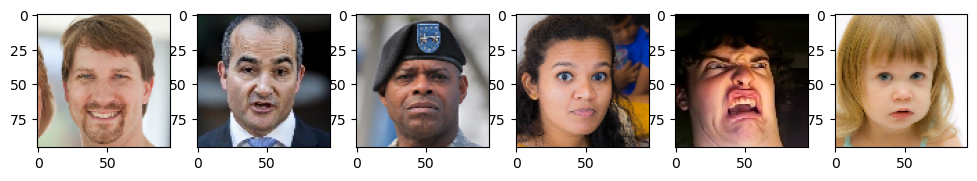

In [5]:
# Take a look at the dataset
imgs = next(iter(test_dataset))
fig = plt.figure(figsize=(12, 8))
rows = 6
for i in range(rows):
    fig.add_subplot(1,rows,i+1)
    plt.imshow((imgs[i]+1)*0.5) #scale images back to [0,1] in order to show them
plt.show()

In [6]:
class DownsampleBlock(layers.Layer):
    def __init__(self, filters, size, strides=2, padding='same',  use_bn=True):
        super().__init__()
        
        self.stack = keras.Sequential()
        self.stack.add(layers.Conv2D(filters, size, strides, padding))
            
        if use_bn:
            self.stack.add(layers.BatchNormalization(momentum=0.5))

        self.stack.add(layers.LeakyReLU(alpha=0.2))

    def call(self, inputs):
        return self.stack(inputs)

In [7]:
class UpsampleBlock(layers.Layer):
    def __init__(self, filters, size=4, strides=2, padding='same', use_bn=True):
        super().__init__()
        
        self.stack = keras.Sequential()
        self.stack.add(layers.Conv2DTranspose(filters, size, strides, padding))
        
        if use_bn:
            self.stack.add(layers.BatchNormalization(momentum=0.5))
            
        self.stack.add(layers.ReLU())

    def call(self, inputs):
        return self.stack(inputs)

In [8]:
def create_generator(input_size=LATENT_DIM):
    inp = layers.Input(shape=(input_size,))
    x = layers.Dense(6*6*512)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((6,6,512))(x)
    x = UpsampleBlock(256,5)(x)
    x = UpsampleBlock(128,5)(x)
    x = UpsampleBlock(64,5)(x)
    x = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
    return keras.models.Model(inp,x,name="generator")

generator = create_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 18432)             2377728   
                                                                 
 batch_normalization (Batch  (None, 18432)             73728     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 18432)             0         
                                                                 
 reshape (Reshape)           (None, 6, 6, 512)         0         
                                                                 
 upsample_block (UpsampleBl  (None, 12, 12, 256)       3278080   
 ock)                                                    

In [9]:
class MinibatchDiscrimination(layers.Layer):

    def __init__(self, num_kernel, dim_kernel,kernel_initializer='glorot_uniform', **kwargs):
        self.num_kernel = num_kernel
        self.dim_kernel = dim_kernel
        self.kernel_initializer = kernel_initializer
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.num_kernel*self.dim_kernel),
                                      initializer=self.kernel_initializer,
                                      trainable=True)
        super(MinibatchDiscrimination, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        activation = tf.matmul(x, self.kernel)
        activation = tf.reshape(activation, shape=(-1, self.num_kernel, self.dim_kernel))
        #Mi
        tmp1 = tf.expand_dims(activation, 3)
        #Mj
        tmp2 = tf.transpose(activation, perm=[1, 2, 0])
        tmp2 = tf.expand_dims(tmp2, 0)
        
        diff = tmp1 - tmp2
        
        l1 = tf.reduce_sum(tf.math.abs(diff), axis=2)
        features = tf.reduce_sum(tf.math.exp(-l1), axis=2)
        return tf.concat([x, features], axis=1)        
        
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + self.num_kernel)

In [10]:
def create_discriminator(input_size=(IMG_SIZE,IMG_SIZE,3)):
    inp = layers.Input(shape=input_size)
    x = DownsampleBlock(64, 5)(inp)
    x = DownsampleBlock(128, 5)(x)
    x = DownsampleBlock(256, 5)(x)
    x = DownsampleBlock(512, 5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = MinibatchDiscrimination(100, 5, name="mbd")(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # x = layers.Dropout(0.4)(x)
    x = layers.Dense(1,activation='sigmoid')(x)
    return keras.models.Model(inp,x,name="discriminator")


discriminator = create_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 downsample_block (Downsamp  (None, 48, 48, 64)        5120      
 leBlock)                                                        
                                                                 
 downsample_block_1 (Downsa  (None, 24, 24, 128)       205440    
 mpleBlock)                                                      
                                                                 
 downsample_block_2 (Downsa  (None, 12, 12, 256)       820480    
 mpleBlock)                                                      
                                                                 
 downsample_block_3 (Downsa  (None, 6, 6, 512)         3279360   
 mpleBlock)                                          

In [11]:
from DiffAugment_tf import DiffAugment

# Custom GAN model
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        '''Init model'''
        super().__init__()
        
        self.generator = generator
        self.discriminator = discriminator
        self.policy = 'color,translation,cutout'
        
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn, latent_dim, **kwargs):
        '''Initialize metrics, optimizers and losses '''
        super().compile(**kwargs)
        
        self.g_loss_mean = keras.metrics.Mean(name="g_loss")
        self.d_loss_mean = keras.metrics.Mean(name="d_loss")
        
        self.real_acc = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_acc = keras.metrics.BinaryAccuracy(name="gen_acc")
        
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        
        # In this example, the same loss function will be provided for both sub-networks (BinaryCrossentropy)
        # However; there are improved GAN variations that use different losses (like WGAN)
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.latent_dim = latent_dim
        
    @property
    def metrics(self):
        return [
            self.g_loss_mean,
            self.d_loss_mean,
            self.real_acc,
            self.generated_acc,
        ]
    
    
    def train_step(self,real_images):
        '''Perform one training step on a single batch of data.'''
        
        batch_size = tf.shape(real_images)[0]
        
        # 1. Train the discriminator
        
        # Generate some images
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim)) # Get noise for generator input
        generated_images = self.generator(random_noise) # Generate images for discriminator training step
        
        
        # Create labels for the discriminator
        # We assume 1 - real image, 0 - fake image + noise (important trick!)
        real_labels = tf.ones((batch_size, 1)) * 0.9
        generated_labels = tf.zeros((batch_size, 1))
        

        # Train the network, update weights manually
        # GradientTape is used to record all calculations inside the network and calculate gradient during backprop
        with tf.GradientTape() as tape:            
            # Divide into two steps because of BatchNormalization
            real_preds = self.discriminator(real_images)            # Predict classes for real images
            generated_preds = self.discriminator(generated_images)  # Predict classes for generated images

            # Labels and predictions of [real,fake] are merged for a discriminator loss function
            d_loss = self.d_loss_fn(tf.concat([real_labels,generated_labels],axis=0), # true labels
                                  tf.concat([real_preds,generated_preds],axis=0))     # predicted labels
          
        # Calculate discriminator gradients
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Apply weight changes
        self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))


        #2. Train the generator
        #[2*] Because discriminator is trained on 2*batch_size number of samples (fake and real)
        random_noise = tf.random.normal(shape=(2*batch_size, self.latent_dim)) #get noise for generator input
        
        
        # During training, the generator tries to deceive the discriminator that it can generate realistic images
        # Therefore, we use "real (1)" labels for the generator
        misleading_labesl = tf.ones((2*batch_size,1))
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_noise) # Generate images
            fake_preds = self.discriminator(generated_images,training=False)
            g_loss = self.g_loss_fn(misleading_labesl, fake_preds)  
      
        # Calculate generator gradients
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)

        # Apply weight changes
        self.g_optimizer.apply_gradients(zip(g_grads,self.generator.trainable_weights))
        
        # Uupdate metrics
        self.g_loss_mean.update_state(g_loss)
        self.d_loss_mean.update_state(d_loss)
        self.real_acc.update_state(1.0, real_preds)
        self.generated_acc.update_state(0.0, generated_preds)
            
        return {'g_loss': g_loss, 'd_loss': d_loss, 
               'real_acc': self.real_acc.result(), 'gen_acc': self.generated_acc.result()}

In [12]:
class ImageProgress(keras.callbacks.Callback):
    def __init__(self,latent_dim,images=6,every_epoch=10):
        '''Provide latent_dim, number of images to plot and frequency.'''
        self.random_vectors = tf.random.normal((images,latent_dim))
        self.every_epoch = every_epoch
        images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % self.every_epoch == 0:
            generated_images = self.model.generator(self.random_vectors,training=False)
        
            fig = plt.figure(figsize=(12, 8))
            for i, image in enumerate(generated_images):
                fig.add_subplot(1,len(self.random_vectors),i+1)
                plt.imshow((image.numpy()+1)*0.5) # Scale output from [-1,1] to [0,1]
            plt.show()

In [13]:
discriminator = create_discriminator()
d_optimizer=keras.optimizers.Adam(0.0004, beta_1=0.5, beta_2=0.9)

generator = create_generator()
g_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)

In [14]:
gan = GAN(generator,discriminator)
gan.compile(g_optimizer,
            d_optimizer,
            keras.losses.BinaryCrossentropy(),
            keras.losses.BinaryCrossentropy(),
            LATENT_DIM)

2024-03-07 21:27:35.004703: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.


Epoch 1/200


2024-03-07 21:27:44.974766: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 21:27:45.181594: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 21:27:45.558855: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 21:27:47.739789: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-07 21:27:48.076479: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

78/79 [============================>.] - ETA: 0s - g_loss: 219.6492 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000

2024-03-07 21:29:08.803828: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-07 21:29:08.966170: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


79/79 [==============================] - ETA: 0s - g_loss: 47.5087 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000 

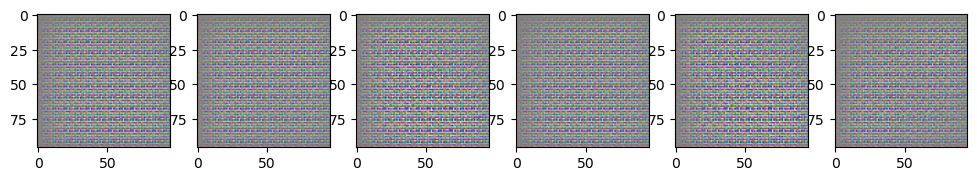

79/79 [==============================] - 99s 830ms/step - g_loss: 263.1257 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 2/200
79/79 [==============================] - 67s 849ms/step - g_loss: 451.5133 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 3/200
79/79 [==============================] - 70s 892ms/step - g_loss: 325.6876 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 4/200
79/79 [==============================] - 72s 910ms/step - g_loss: 242.6451 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 5/200
68/79 [========================>.....] - ETA: 10s - g_loss: 729.9297 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000

2024-03-07 21:33:50.961282: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 952.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


79/79 [==============================] - 75s 946ms/step - g_loss: 764.9279 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 6/200
40/79 [==============>...............] - ETA: 36s - g_loss: 678.9584 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000

2024-03-07 21:34:38.311717: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 952.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


79/79 [==============================] - 74s 942ms/step - g_loss: 673.3478 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 7/200
32/79 [===========>..................] - ETA: 45s - g_loss: 626.7440 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000

2024-03-07 21:35:46.129979: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 952.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


79/79 [==============================] - 75s 954ms/step - g_loss: 609.5510 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 8/200
79/79 [==============================] - 75s 947ms/step - g_loss: 563.6874 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 9/200
79/79 [==============================] - 77s 972ms/step - g_loss: 527.1392 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 10/200
79/79 [==============================] - 75s 950ms/step - g_loss: 497.7343 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 11/200
79/79 [==============================] - ETA: 0s - g_loss: 60.5426 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000 

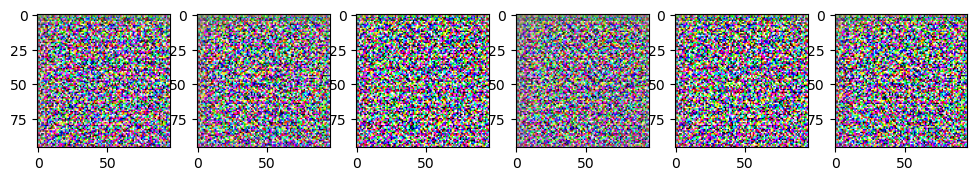

79/79 [==============================] - 71s 897ms/step - g_loss: 474.0438 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 12/200
79/79 [==============================] - 72s 918ms/step - g_loss: 453.8955 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 13/200
67/79 [========================>.....] - ETA: 11s - g_loss: 435.1421 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000

2024-03-07 21:43:49.257410: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 952.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


79/79 [==============================] - 73s 919ms/step - g_loss: 437.0231 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 14/200
79/79 [==============================] - 68s 857ms/step - g_loss: 423.2183 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 15/200
79/79 [==============================] - 69s 878ms/step - g_loss: 410.8192 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 16/200
79/79 [==============================] - 72s 906ms/step - g_loss: 400.1125 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 17/200
79/79 [==============================] - 69s 873ms/step - g_loss: 390.1271 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 18/200
79/79 [==============================] - 62s 786ms/step - g_loss: 381.1909 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 19/200
79/79 [==============================] - 64s 809ms/step - g_loss: 373.6693 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc

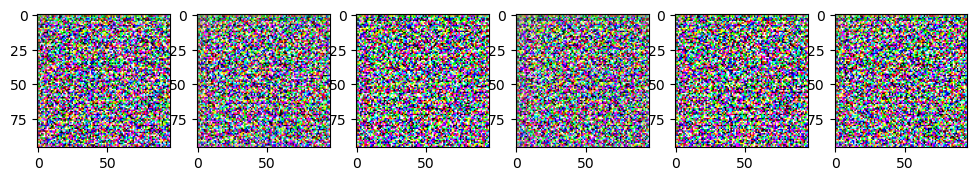

79/79 [==============================] - 68s 865ms/step - g_loss: 360.8539 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 22/200
79/79 [==============================] - 68s 865ms/step - g_loss: 355.1523 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 23/200
79/79 [==============================] - 66s 834ms/step - g_loss: 349.7188 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 24/200
79/79 [==============================] - 64s 803ms/step - g_loss: 344.8688 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 25/200
79/79 [==============================] - 66s 840ms/step - g_loss: 340.8580 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 26/200
79/79 [==============================] - 65s 817ms/step - g_loss: 336.5783 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 27/200
79/79 [==============================] - 63s 800ms/step - g_loss: 333.0919 - d_loss: 6.9412 - real_acc: 0.0000e+00 - gen_acc

KeyboardInterrupt: 

In [15]:
history = gan.fit(train_dataset,
        epochs=200,
        callbacks=[ImageProgress(LATENT_DIM)]) 

In [33]:
g_loss, d_loss, real_acc, fake_acc = history.history.values()

In [34]:
generator.save_weights("generator_faces.h5")
discriminator.save_weights("discriminator_faces.h5")

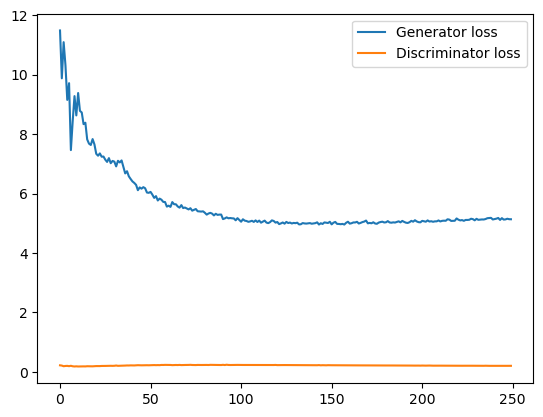

In [35]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

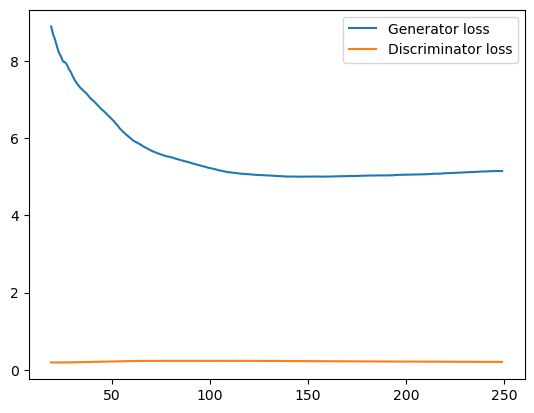

In [36]:
# Lets take a look at the smoothed plot (Simple Moving Average)

window_size = 20
# Convert array of integers to pandas series
d_sma_loss = pd.Series(d_loss)
g_sma_loss = pd.Series(g_loss)
  
# Get the window of series of observations of the specified window size
d_sma_loss = d_sma_loss.rolling(window_size).mean()
g_sma_loss = g_sma_loss.rolling(window_size).mean()

# Convert pandas series back to list
d_sma_loss = d_sma_loss.tolist()
g_sma_loss = g_sma_loss.tolist()

plt.plot(g_sma_loss)
plt.plot(d_sma_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

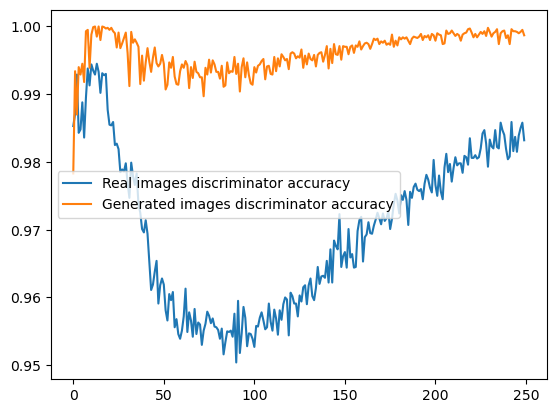

In [37]:
plt.plot(real_acc)
plt.plot(fake_acc)
plt.legend(['Real images discriminator accuracy','Generated images discriminator accuracy'])
plt.show()

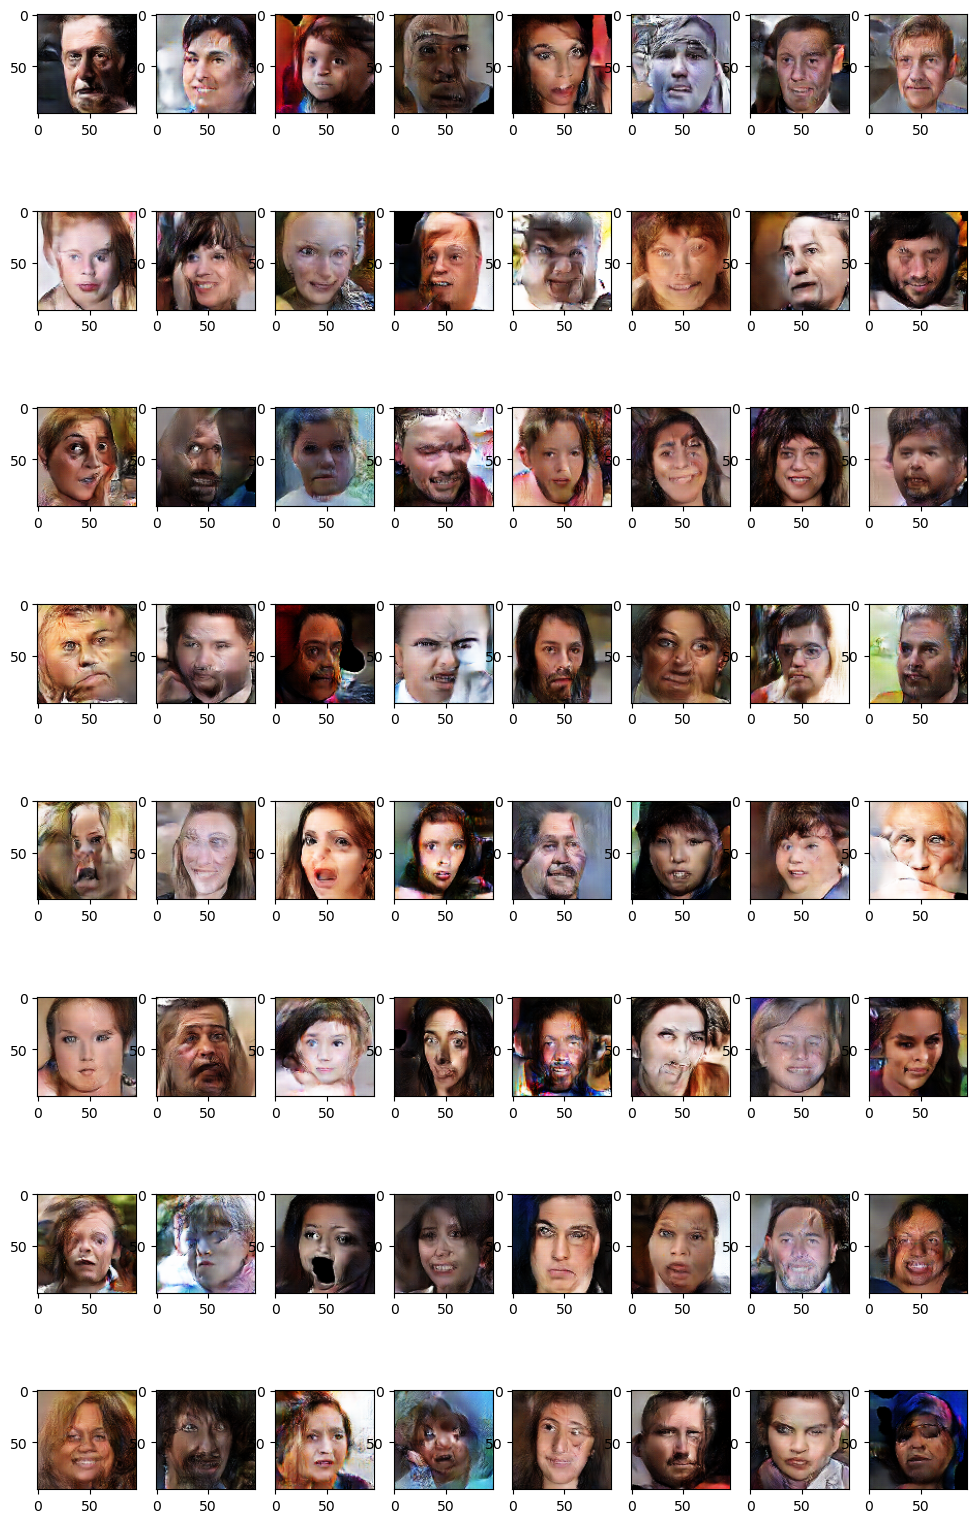

In [38]:
noise = tf.random.normal((64,LATENT_DIM))
generated = generator(noise,training=False)
fig = plt.figure(figsize=(12,20))
for i in range(8):
  for j in range(8):
    fig.add_subplot(8,8,i*8+j+1)
    plt.imshow((generated[i*8+j]+1)*0.5)
plt.show()

In [40]:
# 1. averaging two vectors
examples = 6
noise_1 = np.random.normal(size=(examples,LATENT_DIM))
noise_2 = np.random.normal(size=(examples,LATENT_DIM))
merged = (noise_1 + noise_2)/2 #mean

imgs_1 = generator(noise_1,training=False)
imgs_2 = generator(noise_2,training=False)
result = generator(merged,training=False)

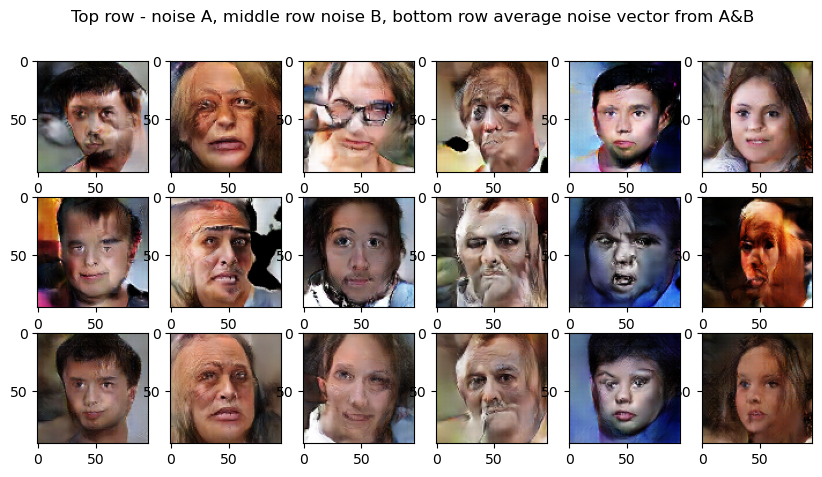

In [41]:
fig = plt.figure(figsize=(10,5))
for i, (a,b,c) in enumerate(zip(imgs_1,imgs_2,result)):
    fig.add_subplot(3,examples,1+i)
    plt.imshow((a+1)*0.5)
    fig.add_subplot(3,examples,examples+i+1)
    plt.imshow((b+1)*0.5)
    fig.add_subplot(3,examples,2*examples+i+1)
    plt.imshow((c+1)*0.5)

fig.suptitle("Top row - noise A, middle row noise B, bottom row average noise vector from A&B")
plt.show()

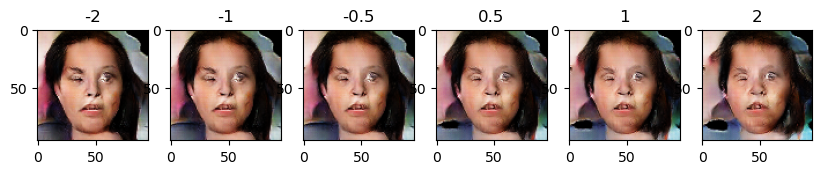

In [42]:
# Feature manipulation (changing single value in the original noise vector) 
noise = np.random.normal(size=(1,LATENT_DIM))
vals = [-2,-1,-0.5,0.5,1,2]                  # values to check
feature = 55                                 # from [0,LATENT_DIM-1]

def plot_feature_change(values,feature,noise):
    fig = plt.figure(figsize=(10,4))
    for index, shift in enumerate(values):
        noise_changed = np.copy(noise)
        noise_changed[0,feature] += shift
        image = generator(noise_changed)
        fig.add_subplot(1,len(vals),1+index)
        plt.imshow((image[0]+1)/2)
        plt.title(shift)
    plt.show()

plot_feature_change(vals,feature,noise)

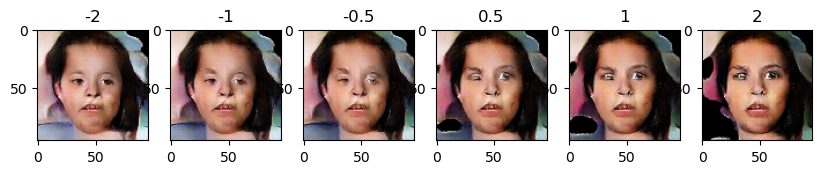

In [43]:
plot_feature_change(vals,11,noise)

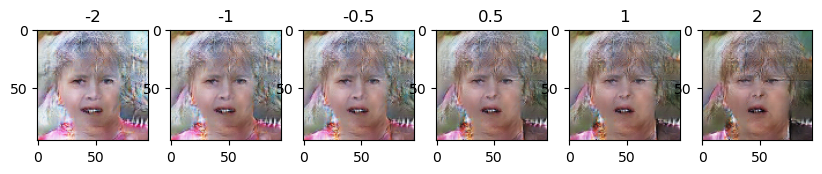

In [44]:
noise = np.random.normal(size=(1,LATENT_DIM)) #new noise
plot_feature_change(vals,11,noise)